# Calculating mRNA level following CRISPRi using qPCR - Fig S7

This code takes raw qPCR data and converts it to relative mRNA expression level for any gene of interest. This data was gathered by growing cells expressing a single sgRNA in M9 + ATc for 5.5 hours and then isolating cellular mRNA. Relative expression levels calculated through normalization to hcaT with the ΔΔCt method.

Written by Ryan Otto 

Last edited 9/23/2020

## Import useful libraries

In [1]:
import pickle # Moving data
import numpy as np # Data organization
import pandas as pd # Data organization
import math # Calculating square roots and powers
from scipy import stats # Calculating linear regression and sem
import matplotlib.pyplot as plt # Plotting function
# Renders figures in notebook
%matplotlib inline

## Establish paths and variables unique to this analysis

In [2]:
input_path = 'inputs/' # General path for input files
figure_path = 'Figures/' # General path for saving figures
df_path = 'outputs/' # General path for data frames

# List of all input files containing qPCR data
file_list = ['20200806_luna_rtqpcr_quant.csv', '20200813_luna_rtqpcr_quant.csv']

# List of all genes to be analyzed, sorted by date of measurement
gene_list = {}
gene_list['20200806'] = ['hcaT', 'topA', 'ribB']
gene_list['20200813'] = ['hcaT', 'ispA', 'mukF', 'tadA']

date = '20200923' # Date for output files

## Import data

In [3]:
cq_dict = {}
for file_name in file_list:
    file_date = file_name[0:8]
    for gene in gene_list[file_date]:
        cq_dict[gene] = {}
for file_name in file_list:
    file_date = file_name[0:8]
    for gene in gene_list[file_date]:
        if gene != 'hcaT':
            cq_dict[gene][gene + '1_C'] = []
            cq_dict[gene][gene + '3_C'] = []
            cq_dict[gene]['Rand42_' + file_date] = []
            cq_dict['hcaT'][gene + '1_C'] = []
            cq_dict['hcaT'][gene + '3_C'] = []
            cq_dict['hcaT']['Rand42_' + file_date] = []
for file_name in file_list:
    file_date = file_name[0:8]
    with open(input_path + file_name, 'r') as f:
        first_line = f.readline()
        for line in f:
            sp = line.split(',')
            if sp[2] != '' and sp[5] != '':
                if sp[2] in gene_list[file_date] and sp[4] in cq_dict[sp[2]].keys():
                    cq_dict[sp[2]][sp[4]].append(float(sp[5]))

## Well Correction

Visual inspection of the first replicate of [hcaT] in Rand42 cells from 20200806 permitted exclusion of this value. Two peaks were present in the melt curve, and the amplification curve was irregular. Exclusion of this data point increases standard error of the mean for future values, compensating for this removal.

In [4]:
print(cq_dict['hcaT']['Rand42_20200806'])

[21.82825813, 23.48359183, 23.68555433]


In [5]:
cq_dict['hcaT']['Rand42_20200806'] = [23.48359183, 23.68555433]

## Relative Expression Calculations

In [6]:
# Find mean and sem of replicate values
cq_mean_dict = {}
cq_sem_dict = {}
for file_name in file_list:
    file_date = file_name[0:8]
    for gene in gene_list[file_date]:
        cq_mean_dict[gene] = {}
        cq_sem_dict[gene] = {}
        for guide in cq_dict[gene].keys():
            # Calculate means for gene of interest and corresponding hcaT abundance
            cq_mean_dict[gene][guide] = np.mean(cq_dict[gene][guide])
            cq_sem_dict[gene][guide] = stats.sem(cq_dict[gene][guide])
# Normalize by hcaT abundance
d_cq_mean_dict = {}
d_cq_sem_dict = {}
for file_name in file_list:
    file_date = file_name[0:8]
    for gene in gene_list[file_date]:
        if gene != 'hcaT':
            d_cq_mean_dict[gene] = {}
            d_cq_sem_dict[gene] = {}
            for guide in cq_mean_dict[gene].keys():
                 # Normalize by hcaT abundance
                d_cq_mean_dict[gene][guide] = cq_mean_dict['hcaT'][guide] - cq_mean_dict[gene][guide]
                d_cq_sem_dict[gene][guide] = math.sqrt(cq_sem_dict['hcaT'][guide]**2 + cq_sem_dict[gene][guide]**2)
# Normalize by target transcript abundance without CRISPRi
dd_cq_mean_dict = {}
dd_cq_sem_dict = {}
for file_name in file_list:
    file_date = file_name[0:8]
    for gene in gene_list[file_date]:
        if gene != 'hcaT':
            dd_cq_mean_dict[gene] = {}
            dd_cq_sem_dict[gene] = {}
            for guide in d_cq_mean_dict[gene].keys():
                 # Normalize by hcaT abundance
                dd_cq_mean_dict[gene][guide] = d_cq_mean_dict[gene][guide] - \
                                               d_cq_mean_dict[gene]['Rand42_' + file_date]
                dd_cq_sem_dict[gene][guide] = math.sqrt(d_cq_sem_dict[gene][guide]**2 + 
                                                        d_cq_sem_dict[gene]['Rand42_' + file_date]**2)
# Transform to a linear scale
dd_cq_mean_lin_dict = {}
dd_cq_sem_lin_dict = {}
for file_name in file_list:
    file_date = file_name[0:8]
    for gene in gene_list[file_date]:
        if gene != 'hcaT':
            dd_cq_mean_lin_dict[gene] = {}
            dd_cq_sem_lin_dict[gene] = {}
            for guide in dd_cq_mean_dict[gene].keys():
                # Take off of log2 scale
                dd_cq_mean_lin_dict[gene][guide] = math.pow(2, dd_cq_mean_dict[gene][guide])
                dd_cq_sem_lin_dict[gene][guide] = np.log(2) * dd_cq_sem_dict[gene][guide] * \
                                                  dd_cq_mean_lin_dict[gene][guide]

## Gene Expression Plotting

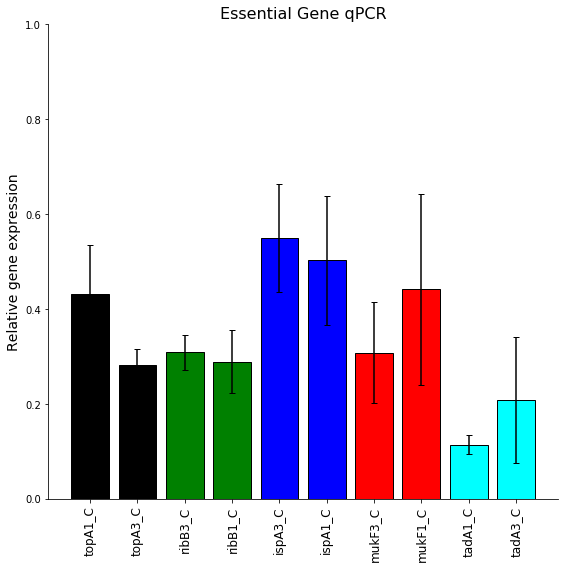

In [7]:
# Figure S7B
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
qPCR_mean = []
qPCR_sem = []
labels = []

col = ['black', 'black', 'green', 'green', 'blue', 'blue', 'red', 'red', 'cyan', 'cyan']
for file_name in file_list:
    file_date = file_name[0:8]
    for i, gene in enumerate(gene_list[file_date]):
        if gene == 'hcaT': # Ignore normalization measurement
            continue
        for guide in dd_cq_mean_dict[gene].keys():
            if not guide.startswith('Rand42'):
                qPCR_mean.append(dd_cq_mean_lin_dict[gene][guide])
                qPCR_sem.append(dd_cq_sem_lin_dict[gene][guide])
                labels.append(guide)
tick_label = labels
index = np.arange(len(qPCR_mean))
ax.bar(index, qPCR_mean, yerr=qPCR_sem, edgecolor='k', color=col, capsize=3)
ax.set_xticks(index)
ax.set_xticklabels(tick_label, rotation=90, fontsize=12)
ax.set_ylim([0, 1])
ax.set_ylabel('Relative gene expression', fontsize=14)
ax.set_title('Essential Gene qPCR', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(figure_path + date + 'essentials_qPCR_FigS7B.pdf', transparent=True)
plt.show()